In [1]:
from navground.sim.ui.web_ui import WebUI
from navground.sim.ui.to_html import notebook_view
from navground.sim.real_time import RealTimeSimulation

web_ui = WebUI(host='127.0.0.1', max_rate=-1, 
               display_collisions=True, display_deadlocks=True)
await web_ui.prepare();

[Errno 48] error while attempting to bind on address ('127.0.0.1', 8000): address already in use


# Deadlocks and Collisions

In this notebook, we will look at two negative events that may happen while navigating: collisions
and deadlocks. We will first learn own to visualize them during a simulation, then how to perform many simulations to assess the impact of two parameters: the safety radius and barrier angle.

We start by specifying an experiment with `safety_margin=0`, which is an unsafe setup that will lead to collisions.

In [2]:
from navground import sim

yaml = """
type: Cross
agent_margin: 0.1
side: 4
target_margin: 0.1
tolerance: 0.5
groups:
  -
    type: thymio
    number: 20
    radius: 0.08
    control_period: 0.1
    speed_tolerance: 0.02
    kinematics:
      type: 2WDiff
      wheel_axis: 0.094
      max_speed: 0.166
    behavior:
      type: HL
      optimal_speed: 0.12
      horizon: 5.0
      tau: 0.5
      eta: 0.25
      safety_margin: 0.0
    state_estimation:
      type: Bounded
      range: 5.0
"""

In [3]:
notebook_view(width=300)

In [4]:
scenario = sim.load_scenario(yaml)
world = sim.World()
scenario.init_world(world, 0)
world.update(0.0)
rt_sim = RealTimeSimulation(world=world, time_step=0.1, factor=10, web_ui=web_ui)
await rt_sim.init()

Runs the simulation for some time. Colliding agents will be colored in red.

In [5]:
until_time = world.time + 120
await rt_sim.run(until=lambda : world.time > until_time or world.agents_are_idle_or_stuck())

You should a similar outcome as in this video, with some agents collising shoulder-to-shoulder.

In [6]:
from IPython.display import Video

Video("collisions.mp4", width=300)

Try now to increase the safety margin to 0.5, which is so large that it will rapidly lead to deadlocked agents, which are colored in blue.

In [7]:
yaml = """
type: Cross
agent_margin: 0.1
side: 4
target_margin: 0.1
tolerance: 0.5
groups:
  -
    type: thymio
    number: 20
    radius: 0.08
    control_period: 0.1
    speed_tolerance: 0.02
    kinematics:
      type: 2WDiff
      wheel_axis: 0.094
      max_speed: 0.166
    behavior:
      type: HL
      optimal_speed: 0.12
      horizon: 5.0
      tau: 0.5
      eta: 0.25
      safety_margin: 0.5
    state_estimation:
      type: Bounded
      range: 5.0
"""

In [8]:
notebook_view(width=300)

In [9]:
scenario = sim.load_scenario(yaml)
world = sim.World()
scenario.init_world(world, 0)
world.update(0.0)
rt_sim = RealTimeSimulation(world=world, time_step=0.1, factor=10, web_ui=web_ui)
await rt_sim.init()

until_time = world.time + 120
await rt_sim.run(until=lambda : world.time > until_time or world.agents_are_idle_or_stuck())

You should a similar outcome has in this video

In [10]:
from IPython.display import Video

Video("deadlocks.mp4", width=300)

In between these two extrema, there should be good trade-off with no collisions and no deadlocks. We invistigate it with an experiment where we vary the safety margin.

In [24]:
from navground import sim

yaml = """
steps: 3000
time_step: 0.1
record_collisions: true
record_deadlocks: true
record_safety_violation: true
record_efficacy: true
terminated_when_idle_or_stuck: true
runs: 250
run_index: 0
scenario:
  type: Cross
  agent_margin: 0.1
  side: 4
  target_margin: 0.1
  tolerance: 0.5
  groups:
    -
      type: thymio
      number: 20
      radius: 0.08
      control_period: 0.1
      speed_tolerance: 0.02
      kinematics:
        type: 2WDiff
        wheel_axis: 0.094
        max_speed: 0.166
      behavior:
        type: HL
        optimal_speed: 0.12
        horizon: 5.0
        tau: 0.5
        eta: 0.5
        safety_margin:
          sampler: uniform
          from: 0.0
          to: 0.25
          once: true
      state_estimation:
        type: Bounded
        range: 5.0
"""

In [25]:
from tqdm.notebook import tqdm

experiment = sim.load_experiment(yaml)
experiment.save_directory = ""

with tqdm() as bar:
    experiment.setup_tqdm(bar)
    experiment.run(keep=True, number_of_threads=8)

0it [00:00, ?it/s]

We import all relevant data into a pandas frame where we also define 
- "safe": no collisions
- "fluid": no deadlocks
- "ok": when safe and fluid

In [26]:
import numpy as np
import pandas as pd


def count_deadlocks(deadlock_time, final_time):
    is_deadlocked = np.logical_and(deadlock_time > 0, deadlock_time < (final_time - 5.0))
    return sum(is_deadlocked)

def extract_data(experiment):
    collisions = []
    deadlocks = []
    efficacy = []
    sms = []
    bas = []
    seeds = []
    for i, run in experiment.runs.items():
        world = run.world
        sm = np.unique([agent.behavior.safety_margin for agent in world.agents])
        ba = np.unique([agent.behavior.barrier_angle for agent in world.agents])
        sms += list(sm)
        bas += list(ba)
        seeds.append(run.seed)
        final_time = run.world.time
        deadlocks.append(count_deadlocks(run.deadlocks, final_time))
        collisions.append(len(run.collisions))
        efficacy.append(run.efficacy.mean())

    df = pd.DataFrame({
        'seeds': seeds,
        'safety_margin': sms, 
        'deadlocks': deadlocks,
        'collisions': collisions,
        'barrier_angle': bas,
        'efficacy': efficacy})
    df['safe'] = (df.collisions == 0).astype(int)
    df['fluid'] = (df.deadlocks == 0).astype(int)
    df['ok'] = ((df.deadlocks == 0) & (df.collisions == 0)).astype(int)
    return df

In [27]:
data = extract_data(experiment)
data.describe()

,seeds,safety_margin,deadlocks,collisions,barrier_angle,efficacy,safe,fluid,ok
count,250.000000,250.000000,250.000000,250.000000,2.500000e+02,250.000000,250.000000,250.000000,250.000000
mean,124.500000,0.127183,2.256000,7.124000,1.570796e+00,0.714524,0.816000,0.796000,0.616000
std,72.312977,0.073709,4.972865,30.377356,2.224900e-16,0.123693,0.388261,0.403777,0.487334
min,0.000000,0.001417,0.000000,0.000000,1.570796e+00,0.216404,0.000000,0.000000,0.000000
25%,62.250000,0.054341,0.000000,0.000000,1.570796e+00,0.698324,1.000000,1.000000,0.000000
50%,124.500000,0.126612,0.000000,0.000000,1.570796e+00,0.760005,1.000000,1.000000,1.000000
75%,186.750000,0.193269,0.000000,0.000000,1.570796e+00,0.794111,1.000000,1.000000,1.000000
max,249.000000,0.249757,18.000000,271.000000,1.570796e+00,0.824171,1.000000,1.000000,1.000000


We plot the consequences of the safety margin on deadlocks and collisions.
We see that 
- for low safety margins, there are collisions 
- for high safety margins, there are deadlocks

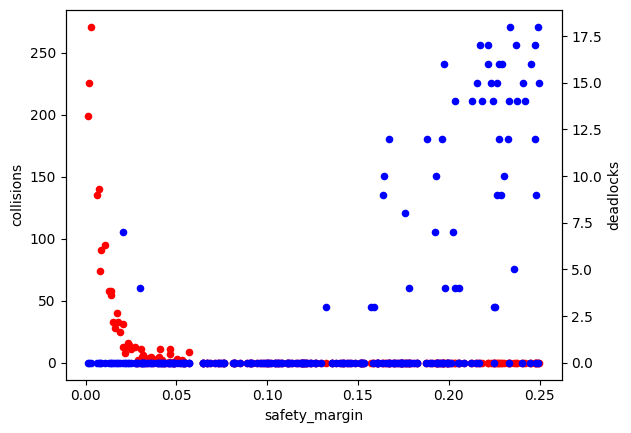

In [28]:
ax = data.plot.scatter(x='safety_margin', y='collisions', color='r')
data.plot.scatter(ax=ax.twinx(), x='safety_margin', y='deadlocks', color='b');

Efficacy measures how much agents are progressing towards their target (1 = ideal, 0 = stuck).
Looking at efficacy gives a more fine-grained picture than deadlocks, which are still visible on the right (points lower than the slowing degrading line).

In [6]:
##### data.plot.scatter(x='safety_margin', y='efficacy', color='k');

Deadlocks can be mitigated by reducing the barrier angle but this may cause collisions.
We investigate the effect of safety margin *and* barrier angle with a larger experiment where we vary both parameters.

In [7]:
from navground import sim

yaml = """
steps: 3000
time_step: 0.1
record_collisions: true
record_deadlocks: true
record_safety_violation: false
record_efficacy: true
terminated_when_idle_or_stuck: true
runs: 5000
scenario:
  type: Cross
  agent_margin: 0.1
  side: 4
  target_margin: 0.1
  tolerance: 0.5
  groups:
    -
      type: thymio
      number: 20
      radius: 0.08
      control_period: 0.1
      speed_tolerance: 0.02
      kinematics:
        type: 2WDiff
        wheel_axis: 0.094
        max_speed: 0.166
      behavior:
        type: HL
        optimal_speed: 0.12
        horizon: 5.0
        tau: 0.5
        eta: 0.5
        safety_margin:
          sampler: uniform
          from: 0.0
          to: 0.25
          once: true
        barrier_angle:
          sampler: uniform
          from: 0.7854
          to: 1.5708
          once: true
      state_estimation:
        type: Bounded
        range: 5.0
"""

In [8]:
experiment = sim.load_experiment(yaml)

with tqdm() as bar:
    experiment.setup_tqdm(bar)
    experiment.run(keep=True, number_of_threads=8)

0it [00:00, ?it/s]

In [14]:
data = extract_data(experiment)
data.describe()

,seeds,safety_margin,deadlocks,collisions,barrier_angle,efficacy,safe,fluid,ok
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,2499.500000,0.123464,0.483400,30.616200,1.179999,0.749188,0.593000,0.951400,0.544400
std,1443.520003,0.072286,2.365596,74.871573,0.227654,0.068232,0.491324,0.215052,0.498075
min,0.000000,0.000033,0.000000,0.000000,0.785570,0.253935,0.000000,0.000000,0.000000
25%,1249.750000,0.061341,0.000000,0.000000,0.982294,0.722176,0.000000,1.000000,0.000000
50%,2499.500000,0.122854,0.000000,0.000000,1.184699,0.764398,1.000000,1.000000,1.000000
75%,3749.250000,0.185237,0.000000,15.000000,1.374994,0.794086,1.000000,1.000000,1.000000
max,4999.000000,0.249975,19.000000,684.000000,1.570611,0.828940,1.000000,1.000000,1.000000


Lower barrier angles reduce safety: 

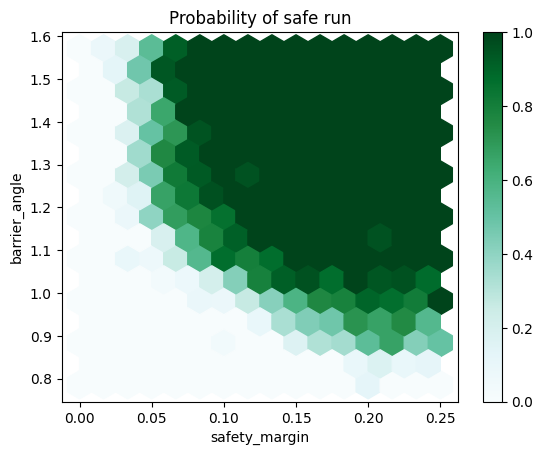

In [19]:
data.plot.hexbin(x="safety_margin", y="barrier_angle", C="safe", 
                 reduce_C_function=np.mean, gridsize=15, 
                 title="Probability of safe run");

Higher barrier angles increase the probability of deadlocks: 

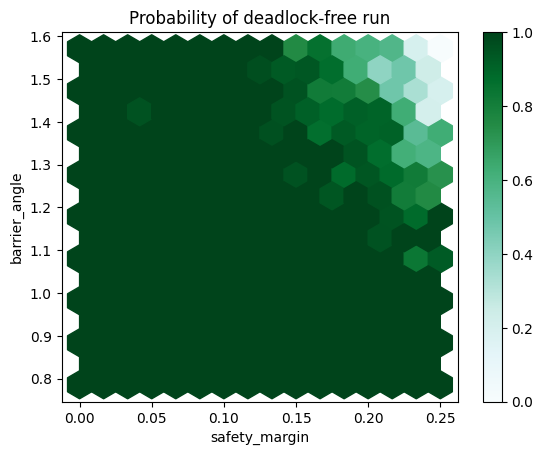

In [20]:
data.plot.hexbin(x="safety_margin", y="barrier_angle", C="fluid", 
                 reduce_C_function=np.mean, gridsize=15,
                 title="Probability of deadlock-free run");

For parameters in the dark green region below, agents are behaving well:

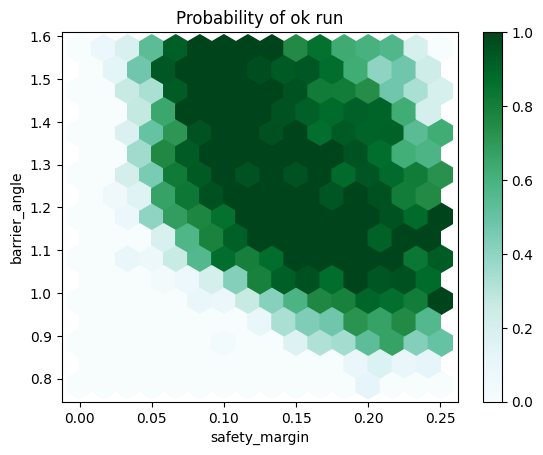

In [21]:
data.plot.hexbin(x="safety_margin", y="barrier_angle", C="ok", 
                 reduce_C_function=np.mean, gridsize=15,
                 title="Probability of ok run");

Finally, we also plot the efficacy:

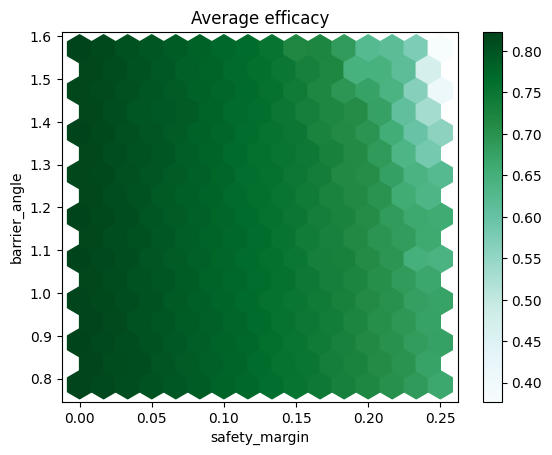

In [23]:
data.plot.hexbin(x="safety_margin", y="barrier_angle", C="efficacy", 
                 reduce_C_function=np.mean, gridsize=15,
                 title="Average efficacy");